# Environment Specification

1. Operating System: Windows 11
2. Python Version: 3.8.20
3. TensorFlow Version: 2.6.0-GPU
4. GPU: NVIDIA GeForce RTX 4070 Laptop GPU
5. CUDA Version: 11.2
6. Installed Packages:
   - NumPy: 1.21.5
   - Pandas: 1.3.5
   - Scikit-learn: 1.0.2
   - Matplotlib: 3.4.3
   - Seaborn: 0.11.2
7. Hardware:
   - CPU: 13th Gen Intel(R) Core(TM) i9-13900H
   - RAM: 16 GB

# Import Necessary Libraries

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
!pip install opencv-python
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

In [2]:
def seed_everything(seed=42):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy's random number generator
    np.random.seed(seed)
    
    # Set the seed for TensorFlow's random number generator
    tf.random.set_seed(seed)
    
    # Set the PYTHONHASHSEED environment variable to ensure reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Configure TensorFlow to use a single thread for operations
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    
    # Enable deterministic operations in TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Call the function to set all seeds
seed_everything()

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
import zipfile

# Unzip Training.zip and Testing.zip
zip_path = 'raw-img.zip'

# Directories to extract the zip files
zip_dir = 'raw-img'

# Unzip Training.zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(zip_dir)

# Load and Transform Data

In [5]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

# Walk through each directory
dataset = 'raw-img'
walk_through_dir(dataset)

There are 10 directories and 0 images in 'raw-img'.
There are 0 directories and 2112 images in 'raw-img\butterfly'.
There are 0 directories and 1668 images in 'raw-img\cat'.
There are 0 directories and 3098 images in 'raw-img\chicken'.
There are 0 directories and 1866 images in 'raw-img\cow'.
There are 0 directories and 4863 images in 'raw-img\dog'.
There are 0 directories and 1446 images in 'raw-img\elefant'.
There are 0 directories and 2623 images in 'raw-img\horse'.
There are 0 directories and 1820 images in 'raw-img\sheep'.
There are 0 directories and 4821 images in 'raw-img\spider'.
There are 0 directories and 1862 images in 'raw-img\squirrel'.


In [6]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    # filepaths 使用 glob 方法查找目录中的所有图片文件路径，包括 .JPG, .jpg, .jpeg, 和 .PNG 扩展名。
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    
    # os.path.split(x)[0] 获取每个文件路径的上一级目录（即文件所在的文件夹）。
    # os.path.split(...)[1] 获取该目录名作为标签（假设文件夹名代表图片的类别）
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # 将 filepaths 和 labels 列表转换为 Pandas Series，并分别命名为 "Filepath" 和 "Label" 列
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

C:\Users\10422\AppData\Local\Temp\ipykernel_10360\2361829875.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
C:\Users\10422\AppData\Local\Temp\ipykernel_10360\2361829875.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(label_counts.index, rotation=45)


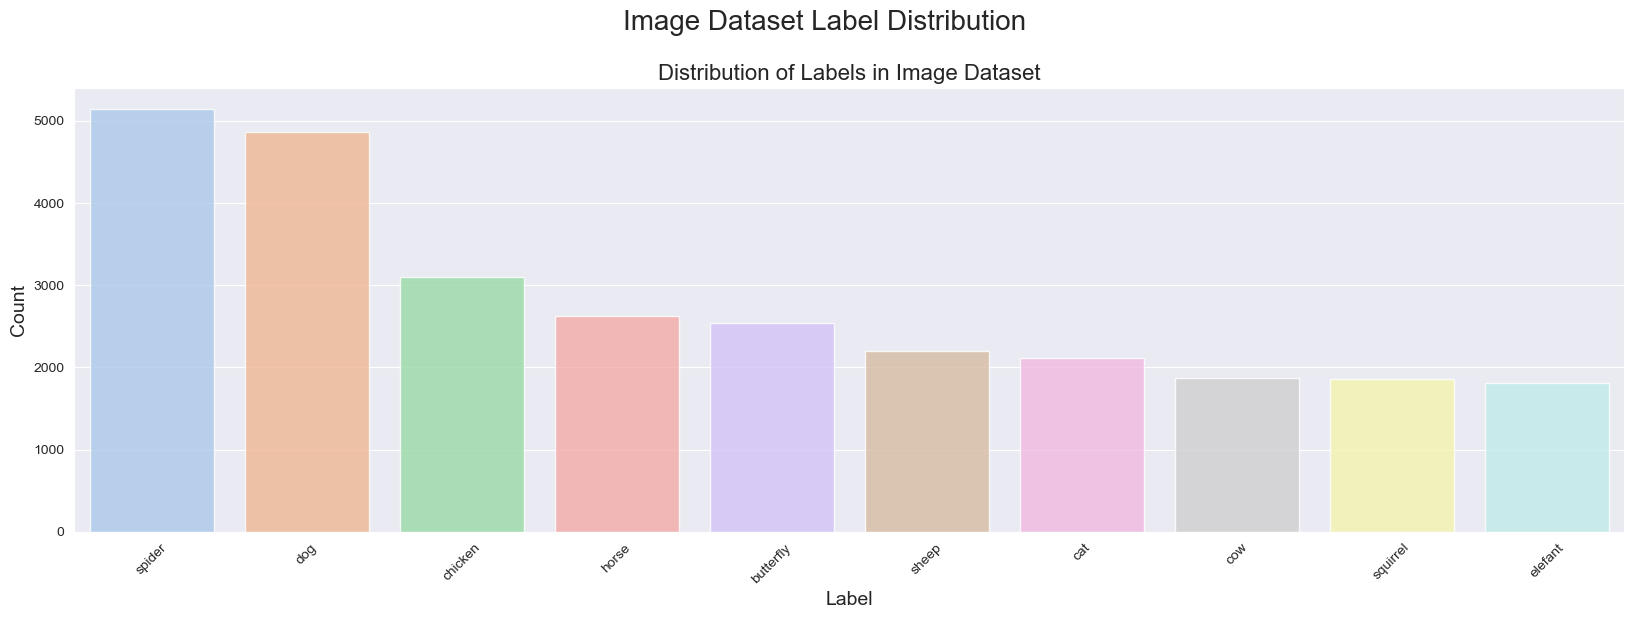

In [8]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes)
axes.set_title('Distribution of Labels in Image Dataset', fontsize=16)
axes.set_xlabel('Label', fontsize=14)
axes.set_ylabel('Count', fontsize=14)
axes.set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

# Visualizing images from the dataset

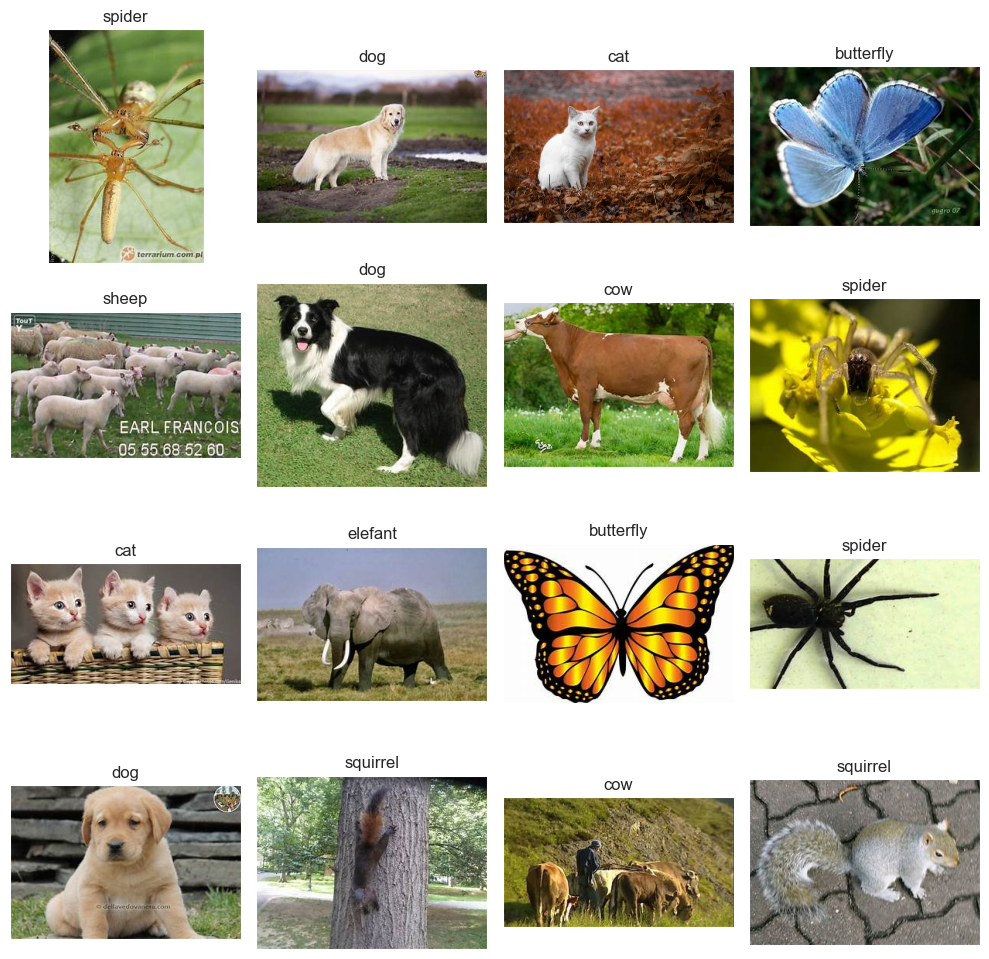

In [9]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [12]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

# Data Preprocessing

In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [15]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 17983 validated image filenames belonging to 10 classes.
Found 4495 validated image filenames belonging to 10 classes.
Found 5620 validated image filenames belonging to 10 classes.


In [16]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Training the model

The model images will be subjected to a pre-trained CNN model called EfficientNetB7. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

Batch size: 32
Epochs: 100
Input Shape: (224, 224, 3)
Output layer: 10

In [17]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [18]:
# Create checkpoint callback
checkpoint_path = 'animals_classification_model_checkpoint.weights.h5'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = 'val_loss', # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [19]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)


outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback('training_logs', 
                                    'animals_classification'),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/animals_classification/20241116-184940


D:\anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/100
562/562 [==============================] - 327s 503ms/step - loss: 2.6945 - accuracy: 0.2451 - val_loss: 1.1130 - val_accuracy: 0.6770
Epoch 2/100
562/562 [==============================] - 267s 475ms/step - loss: 1.5931 - accuracy: 0.5109 - val_loss: 0.6127 - val_accuracy: 0.8581
Epoch 3/100
562/562 [==============================] - 263s 467ms/step - loss: 1.0969 - accuracy: 0.6516 - val_loss: 0.4067 - val_accuracy: 0.9101
Epoch 4/100
562/562 [==============================] - 261s 465ms/step - loss: 0.8315 - accuracy: 0.7433 - val_loss: 0.2989 - val_accuracy: 0.9313
Epoch 5/100
562/562 [==============================] - 264s 469ms/step - loss: 0.6619 - accuracy: 0.8008 - val_loss: 0.2457 - val_accuracy: 0.9399
Epoch 6/100
562/562 [==============================] - 263s 468ms/step - loss: 0.5549 - accuracy: 0.8349 - val_loss: 0.2117 - val_accuracy: 0.9442
Epoch 7/100
562/562 [==============================] - 263s 467ms/step - loss: 0.4734 - accuracy: 0.8613 - val_loss: 0

In [20]:
import json

history_dict = {key: [float(value) for value in values] for key, values in history.history.items()}

with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)